Does going to university in a different country affect your mental health? A Japanese international university surveyed its students in 2018 and published a study the following year that was approved by several ethical and regulatory boards.

The study found that international students have a higher risk of mental health difficulties than the general population, and that social connectedness (belonging to a social group) and acculturative stress (stress associated with joining a new culture) are predictive of depression.

Explore the students data using PostgreSQL to find out if you would come to a similar conclusion for international students and see if the length of stay is a contributing factor.

-----------------------------------------------------------------------

###Field Name	Description
####inter_dom	Types of students (international or domestic)
####japanese_cate	Japanese language proficiency
####english_cate	English language proficiency
####academic	Current academic level (undergraduate or graduate)
####age	Current age of student
####stay	Current length of stay in years
####todep	Total score of depression (PHQ-9 test)
####tosc	Total score of social connectedness (SCS test)
####toas	Total score of acculturative stress (ASISS test)

 # Start the Spark activation process

In [1]:
# Install OpenJDK 8 (Java Development Kit) without displaying output messages
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark version 3.1.1 along with Hadoop 3.2 binaries without displaying output messages
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

# Extract the downloaded Spark archive without displaying output messages
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

# Install the findspark library quietly (without displaying output messages)
!pip install -q findspark

In [2]:
# Import os libraries
import pandas as pd
import os
import findspark
import matplotlib.pyplot as plt

# Set the environment variable "JAVA_HOME" to the path of the installed OpenJDK 8
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# Set the environment variable "SPARK_HOME" to the path of the extracted Spark 3.1.1 binaries
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Initialize findspark to automatically set the Spark-related environment variables
findspark.init()
# Import the SparkSession class from the pyspark.sql module
from pyspark.sql import SparkSession
from pyspark.sql.functions import round

# Create a SparkSession and show Spark functionalities

In [3]:
# Create a SparkSession with a local master and "*" as the number of worker threads
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Enable eager evaluation for Spark SQL REPL (Read-Eval-Print Loop) for better output table formatting
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# Display the SparkSession object, which provides access to Spark functionality
spark

# Load a DataFrame DF

In [4]:
# Load the student.csv into a dataframe
s = spark.read.csv("students.csv", header=True, inferSchema=True)

In [5]:
#Show informations of the DF
s.printSchema()

root
 |-- inter_dom: string (nullable = true)
 |-- region: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- academic: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_cate: integer (nullable = true)
 |-- stay: integer (nullable = true)
 |-- stay_cate: string (nullable = true)
 |-- japanese: integer (nullable = true)
 |-- japanese_cate: string (nullable = true)
 |-- english: integer (nullable = true)
 |-- english_cate: string (nullable = true)
 |-- intimate: string (nullable = true)
 |-- religion: string (nullable = true)
 |-- suicide: string (nullable = true)
 |-- dep: string (nullable = true)
 |-- deptype: string (nullable = true)
 |-- todep: integer (nullable = true)
 |-- depsev: string (nullable = true)
 |-- tosc: integer (nullable = true)
 |-- apd: integer (nullable = true)
 |-- ahome: integer (nullable = true)
 |-- aph: integer (nullable = true)
 |-- afear: integer (nullable = true)
 |-- acs: integer (nullable = true)
 |-- aguilt: integer (n

In [6]:
#Show the first 5 lines of the DataFrame using Spark
s.show(5)

+---------+------+------+--------+---+--------+----+---------+--------+-------------+-------+------------+--------+--------+-------+---+-------+-----+------+----+---+-----+---+-----+---+------+--------+----+-------+-------+-------+--------+-------+------+------+----+-----+------+--------+----------+----------+----------+-----------+---------------+--------+---------+-----------+--------+---------+-----------+
|inter_dom|region|gender|academic|age|age_cate|stay|stay_cate|japanese|japanese_cate|english|english_cate|intimate|religion|suicide|dep|deptype|todep|depsev|tosc|apd|ahome|aph|afear|acs|aguilt|amiscell|toas|partner|friends|parents|relative|profess| phone|doctor|reli|alone|others|internet|partner_bi|friends_bi|parents_bi|relative_bi|professional_bi|phone_bi|doctor_bi|religion_bi|alone_bi|others_bi|internet_bi|
+---------+------+------+--------+---+--------+----+---------+--------+-------------+-------+------------+--------+--------+-------+---+-------+-----+------+----+---+-----+--

In [7]:
#Show the first 5 lines of the DataFrame using Spark
s.limit(5)

inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,english,english_cate,intimate,religion,suicide,dep,deptype,todep,depsev,tosc,apd,ahome,aph,afear,acs,aguilt,amiscell,toas,partner,friends,parents,relative,profess,phone,doctor,reli,alone,others,internet,partner_bi,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
Inter,SEA,Male,Grad,24,4,5,Long,3,Average,5,High,null,Yes,No,No,No,0,Min,34,23,9,11,8,11,2,27,91,5,5,6,3,2,1,4,1,3,4,null,Yes,Yes,Yes,No,No,No,No,No,No,No,No
Inter,SEA,Male,Grad,28,5,1,Short,4,High,4,High,null,No,No,No,No,2,Min,48,8,7,5,4,3,2,10,39,7,7,7,4,4,4,4,1,1,1,null,Yes,Yes,Yes,No,No,No,No,No,No,No,No
Inter,SEA,Male,Grad,25,4,6,Long,4,High,4,High,Yes,Yes,No,No,No,2,Min,41,13,4,7,6,4,3,14,51,3,3,3,1,1,2,1,1,1,1,null,No,No,No,No,No,No,No,No,No,No,No
Inter,EA,Female,Grad,29,5,1,Short,2,Low,3,Average,No,No,No,No,No,3,Min,37,16,10,10,8,6,4,21,75,5,5,5,5,5,2,2,2,4,4,null,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No
Inter,EA,Female,Grad,28,5,1,Short,1,Low,3,Average,Yes,No,No,No,No,3,Min,37,15,12,5,8,7,4,31,82,5,5,5,2,5,2,5,5,4,4,null,Yes,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No


In [8]:
#Show Columns names
s.columns

['inter_dom',
 'region',
 'gender',
 'academic',
 'age',
 'age_cate',
 'stay',
 'stay_cate',
 'japanese',
 'japanese_cate',
 'english',
 'english_cate',
 'intimate',
 'religion',
 'suicide',
 'dep',
 'deptype',
 'todep',
 'depsev',
 'tosc',
 'apd',
 'ahome',
 'aph',
 'afear',
 'acs',
 'aguilt',
 'amiscell',
 'toas',
 'partner',
 'friends',
 'parents',
 'relative',
 'profess',
 ' phone',
 'doctor',
 'reli',
 'alone',
 'others',
 'internet',
 'partner_bi',
 'friends_bi',
 'parents_bi',
 'relative_bi',
 'professional_bi',
 'phone_bi',
 'doctor_bi',
 'religion_bi',
 'alone_bi',
 'others_bi',
 'internet_bi']

In [9]:
#Show test columns : todep / tosc / toas
s.select('todep', 'tosc', 'toas').show()

+-----+----+----+
|todep|tosc|toas|
+-----+----+----+
|    0|  34|  91|
|    2|  48|  39|
|    2|  41|  51|
|    3|  37|  75|
|    3|  37|  82|
|    6|  38|  83|
|    3|  46|  58|
|    9|  41| 127|
|    7|  36| 109|
|    3|  48|  51|
|    5|  32|  92|
|    8|  47|  95|
|    1|  48|  54|
|    3|  32|  57|
|    9|  31| 112|
|    6|  40|  74|
|    3|  48|  63|
|    3|  48|  47|
|    7|  44|  55|
|    1|  36|  60|
+-----+----+----+
only showing top 20 rows



# Show some Statistics using Spark

In [10]:
# Show Max of todep
s.agg({'todep':'max'}).show()

+----------+
|max(todep)|
+----------+
|        25|
+----------+



In [11]:
# Show Min of todep
s.agg({'todep':'min'}).show()

+----------+
|min(todep)|
+----------+
|         0|
+----------+



In [12]:
# Show Avg of todep
s.agg({'todep':'avg'}).show()

+-----------------+
|       avg(todep)|
+-----------------+
|8.186567164179104|
+-----------------+



In [13]:
# Round the AVG value
avg_todep = s.agg({'todep': 'avg'})
round_avg = avg_todep.withColumn('avg(todep)', round(avg_todep['avg(todep)'], 2))
round_avg.show()

+----------+
|avg(todep)|
+----------+
|      8.19|
+----------+



In [14]:
# Show some statistical description
s.describe()

summary,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,english,english_cate,intimate,religion,suicide,dep,deptype,todep,depsev,tosc,apd,ahome,aph,afear,acs,aguilt,amiscell,toas,partner,friends,parents,relative,profess,phone,doctor,reli,alone,others,internet,partner_bi,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
count,268,268,268,268,268,268,268,268,268,268,268,268,260,268,268,270,271,268,273,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,242,283,283,272,272,272,272,272,272,272,272,272
mean,null,null,null,null,20.87313432835821,2.5597014925373136,2.1492537313432836,null,3.0970149253731343,null,3.6492537313432836,null,null,null,null,134.0,89.33333333333333,8.186567164179104,53.6,37.473880597014926,15.414179104477611,9.60820895522388,9.138059701492537,7.257462686567164,6.063432835820896,3.783582089552239,21.115671641791046,72.38059701492537,4.32089552238806,4.063432835820896,4.373134328358209,3.0708955223880596,2.9477611940298507,2.287313432835821,2.671641791044776,1.9179104477611941,2.9402985074626864,2.1417910447761193,3.020661157024793,86.6,181.4,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0
stddev,null,null,null,null,2.7652786783892576,1.0706237044601954,1.326804969095303,null,1.306104382870079,null,0.8805638531215252,null,null,null,null,53.74011537017761,71.84242015225638,4.954728246001668,41.614901177342716,9.234120323181463,6.174438705752721,4.011155763980721,4.194651396837605,3.111676135041855,2.600721335972424,1.909416603251278,7.402149242273197,22.644887568181296,2.233891974187523,1.9352066751698362,2.072367304331111,1.853888498756755,1.8290914392998283,1.5298244320109695,1.7147787636556566,1.4065044590929987,2.030705100806051,1.5048136748031495,1.7199062676077244,49.38015795843509,49.13363700881796,3.4641016151377544,78.5196366097891,84.29313930168536,120.08885599144216,101.61364737737414,132.7905619136139,79.67433714816836,130.48116083685542,102.7683479157534
min,Dom,EA,Female,Grad,17,1,1,Long,1,Average,1,Average,No,No,No,172,172,0,107,8,8,4,5,4,3,2,10,36,1,1,1,1,1,1,1,1,1,1,1,123,123,131,202,207,238,222,19,203,21,223
max,Inter,SEA,Male,Under,31,5,10,Short,5,Low,5,Low,Yes,Yes,Yes,Yes,Other,25,Sev,48,39,20,25,17,13,10,47,145,7,7,7,7,7,7,7,7,7,7,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


# Working with spark.sql

In [15]:
#creates a temporary view named "students".
s.createOrReplaceTempView("students")

In [16]:
spark.sql('SELECT * FROM students').show()

+---------+------+------+--------+---+--------+----+---------+--------+-------------+-------+------------+--------+--------+-------+---+-------+-----+------+----+---+-----+---+-----+---+------+--------+----+-------+-------+-------+--------+-------+------+------+----+-----+------+--------+----------+----------+----------+-----------+---------------+--------+---------+-----------+--------+---------+-----------+
|inter_dom|region|gender|academic|age|age_cate|stay|stay_cate|japanese|japanese_cate|english|english_cate|intimate|religion|suicide|dep|deptype|todep|depsev|tosc|apd|ahome|aph|afear|acs|aguilt|amiscell|toas|partner|friends|parents|relative|profess| phone|doctor|reli|alone|others|internet|partner_bi|friends_bi|parents_bi|relative_bi|professional_bi|phone_bi|doctor_bi|religion_bi|alone_bi|others_bi|internet_bi|
+---------+------+------+--------+---+--------+----+---------+--------+-------------+-------+------------+--------+--------+-------+---+-------+-----+------+----+---+-----+--

In [17]:
#Count all of the records in the data
spark.sql(
    'SELECT COUNT(*) AS total_records FROM students'
        ).show()

+-------------+
|total_records|
+-------------+
|          286|
+-------------+



In [18]:
#Count all of the records in the data per student type
spark.sql('SELECT COUNT(*) count_inter_dom FROM students GROUP BY inter_dom').show()

+---------------+
|count_inter_dom|
+---------------+
|             18|
|            201|
|             67|
+---------------+



In [19]:
#Filter the data to see how it differs between the student types
spark.sql('SELECT inter_dom, COUNT(*) AS count_inter_dom FROM students GROUP BY inter_dom').show()

+---------+---------------+
|inter_dom|count_inter_dom|
+---------+---------------+
|     null|             18|
|    Inter|            201|
|      Dom|             67|
+---------+---------------+



In [20]:
#Find the average scores by length of stay for international students, and view them in the order
result = spark.sql(
"""
SELECT stay,
  ROUND(AVG(todep), 2) AS average_phq,
  ROUND(AVG(tosc), 2) AS average_scs,
  ROUND(AVG(toas), 2) AS average_as
FROM students
WHERE inter_dom = 'Inter'
GROUP BY stay
ORDER BY stay ASC
""")

In [21]:
result.show()

+----+-----------+-----------+----------+
|stay|average_phq|average_scs|average_as|
+----+-----------+-----------+----------+
|   1|       7.48|      38.11|      72.8|
|   2|       8.28|      37.08|     77.67|
|   3|       9.09|      37.13|      78.0|
|   4|       8.57|      33.93|     87.71|
|   5|        0.0|       34.0|      91.0|
|   6|        6.0|       38.0|     58.67|
|   7|        4.0|       48.0|      45.0|
|   8|       10.0|       44.0|      65.0|
|  10|       13.0|       32.0|      50.0|
+----+-----------+-----------+----------+



# Plot the results

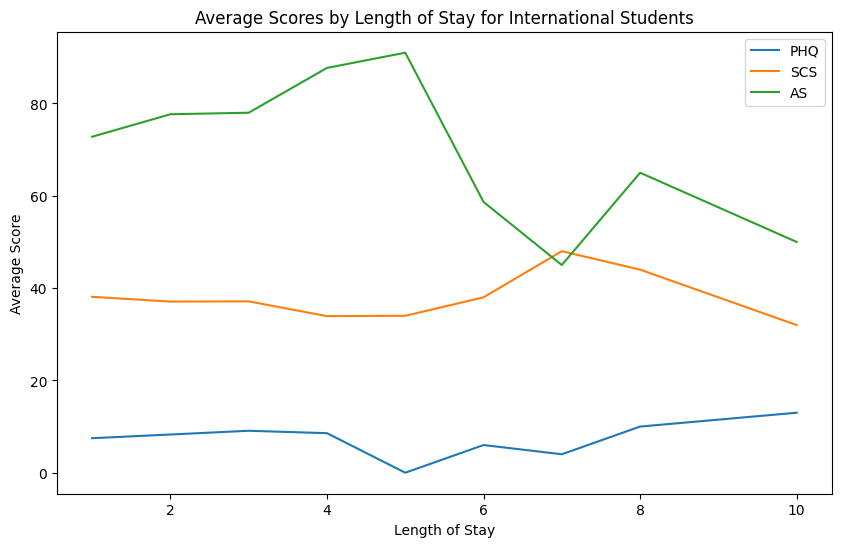

In [22]:
# Convert the result DataFrame to a Pandas DataFrame for plotting
result_pd = result.toPandas()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(result_pd['stay'], result_pd['average_phq'], label='PHQ')
plt.plot(result_pd['stay'], result_pd['average_scs'], label='SCS')
plt.plot(result_pd['stay'], result_pd['average_as'], label='AS')
plt.title('Average Scores by Length of Stay for International Students')
plt.xlabel('Length of Stay')
plt.ylabel('Average Score')
plt.legend()
plt.show()
